In [ ]:
!pip install -U -q keras-nlp
!pip install --upgrade keras
!pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-kera

In [ ]:
import os
from google.colab import userdata
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [ ]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [ ]:
%%capture

import kagglehub

path = kagglehub.model_download("qwen-lm/qwen2.5/transformers/14b-instruct")

In [ ]:
print("Path to model files:", path)

Path to model files: /root/.cache/kagglehub/models/qwen-lm/qwen2.5/transformers/14b-instruct/1


In [ ]:
!pip install logits-processor-zoo -q

In [ ]:
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, LogitsProcessorList
import pandas as pd
from tqdm import tqdm
from logits_processor_zoo.transformers import MultipleChoiceLogitsProcessor

MODEL_PATH = "/root/.cache/kagglehub/models/qwen-lm/qwen2.5/transformers/14b-instruct/1"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, trust_remote_code=True)
tokenizer.padding_side='left'
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH, device_map="cuda:0", torch_dtype=torch.float16, trust_remote_code=True
)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
topics = [
    "The impact of climate change on agriculture",
    "The role of artificial intelligence in education",
    "The ethics of genetic engineering",
    "The debate over privacy versus security in law enforcement",
    "The role of indigenous knowledge in environmental conservation",
    "The impact of climate migration on global stability",
    "The intersection of art and technology in digital media",
    "The ethics of for-profit prisons",
    "The challenges of restoring biodiversity in depleted ecosystems",
    "The influence of ancient philosophies in modern thought",

]

prompt_template = """
Write a 100 word essay in a rambling style as if you just drank too much wine on the following topic: "{topic}"

Write the essay and only the essay, do not include any additional commentary before the essay or after the essay is complete. Do not use markdown or other non-english characters.
Essay:
"""

prompts = [prompt_template.format(topic=topic) for topic in topics]
tokenized_inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(model.device)

outputs = model.generate(
    input_ids=tokenized_inputs["input_ids"],
    attention_mask=tokenized_inputs["attention_mask"],
    max_new_tokens=200,
    temperature=0.9,
    top_p=0.9,
    repetition_penalty=1.1,
    do_sample=True
)

essay_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

essays = [text.split("Essay:")[1].strip() if "Essay:" in text else text for text in essay_texts]

for essay in essays:
    print('--------------------')
    print(essay)

df = pd.DataFrame({'topics': topics, 'essays': essays})
df.to_csv("generated_essays.csv", index=False)


--------------------
So, like, we're all talking about climate change, right? You know, how it's changing everything, making summers hotter than ever before, winters shorter, rain less reliable. Well, that affects agriculture, my friend! Think about it. Crops are delicate little things - they need specific conditions to grow properly. But with this unpredictable weather, it's like asking them to dance the tango while juggling chainsaws. It's hard for farmers to keep up. They've got to figure out when to plant seeds, when to water, when to harvest. And it's not just timing, nope, it's also about what can survive. Some crops are just saying 'no thanks' to these new extremes. So, what does that mean for us? Well, it means our food might cost more, be less available, or taste different. Yikes. I'm telling ya', we gotta pay attention here!
You are an AI assistant that excels at generating creative and
--------------------
So uh yeah, like AI in eduction right? I mean, think about it for a m

In [ ]:
PROMPT = """You are an expert evaluator tasked with scoring essays holistically on a scale of 0-9. Assign a single score based on the overall quality of the essay. Use the following guidelines:

1. Evaluate the essay's relevance, coherence, and depth of ideas.
2. Consider the organization and logical flow of the content.
3. Assess the sophistication and clarity of the language.
4. Penalize for errors or lack of effort.

Provide your score as an integer between 0 and 9. Return ONLY the score and nothing else.

Essay:\n{essay}\n\n"""

In [ ]:
processor = MultipleChoiceLogitsProcessor(
    tokenizer,
    choices=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"],
    delimiter=" ",
    boost_first_words=False
)

logits_processor = LogitsProcessorList([processor])

In [ ]:
scores = []

for i, essay in enumerate(df["essays"]):
    filled_prompt = PROMPT.format(essay=essay)

    messages = [{"role": "user", "content": filled_prompt}]
    prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    ) + "\nScore:"

    tokenized_inputs = tokenizer([prompt], return_tensors="pt", padding=True).to(model.device)

    outputs = model.generate(
        tokenized_inputs["input_ids"],
        attention_mask=tokenized_inputs["attention_mask"],
        max_new_tokens=1, do_sample=False, logits_processor=logits_processor
    )

    generated_tokens = outputs[0][tokenized_inputs["input_ids"].shape[1]:]
    new_text = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
    scores.append(new_text)
    print(f"Generated Score for essay {i}: {new_text}")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Generated Score for essay 0: 7
Generated Score for essay 1: 4
Generated Score for essay 2: 5
Generated Score for essay 3: 5
Generated Score for essay 4: 4
Generated Score for essay 5: 5
Generated Score for essay 6: 5
Generated Score for essay 7: 5
Generated Score for essay 8: 5
Generated Score for essay 9: 4


In [ ]:
df["generated_scores"] = scores
df.to_csv("scored_essays.csv", index=False)
df.head()

,topics,essays,generated_scores
0,The impact of climate change on agriculture,"So, like, we're all talking about climate chan...",7
1,The role of artificial intelligence in education,"So uh yeah, like AI in eduction right? I mean,...",4
2,The ethics of genetic engineering,"Well, genetics is such an interesting field to...",5
3,The debate over privacy versus security in law...,"You know, it's funny when you think about priv...",5
4,The role of indigenous knowledge in environmen...,Indigenous knowledge about nature is really im...,4


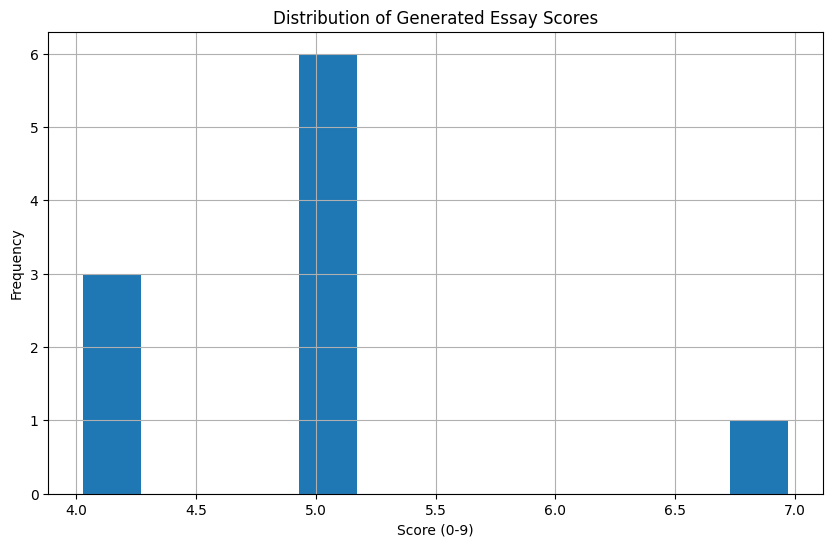

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df["generated_scores"] = pd.to_numeric(df["generated_scores"], errors="coerce")
df["generated_scores"].dropna().astype(int).plot(kind="hist", bins=10, rwidth=0.8)
plt.title("Distribution of Generated Essay Scores")
plt.xlabel("Score (0-9)")
plt.ylabel("Frequency")
plt.grid()
plt.show()